In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [3]:
from torch.utils.data import Dataset
import torch

class MNISTData(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        raise NotImplementedError("This method should be overridden by subclasses")

class MNISTTrainData(MNISTData):
    def __getitem__(self, idx):
        X = self.data[idx][1:].reshape(1, 28, 28) / 255.0
        y = self.data[idx][0]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return X, y

class MNISTTestData(MNISTData):
    def __getitem__(self, idx):
        X = self.data[idx].reshape(1, 28, 28) / 255.0
        X = torch.tensor(X, dtype=torch.float32)
        return X

In [4]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_data, val_data = train_test_split(data, random_state = 42)

In [7]:
train_data.shape

(31500, 785)

In [8]:
val_data.shape

(10500, 785)

In [9]:
train_data = MNISTTrainData(train_data.values)
test_data = MNISTTestData(test_data.values)
val_data = MNISTTrainData(val_data.values)

In [10]:
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
model = CNN()

In [53]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): CNN(
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (fc1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [54]:
import torch.optim as optim

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.001)

In [56]:
import copy

In [57]:
best_loss = float('inf')
best_model_weights = None
patience = 3
best_model_weights = copy.deepcopy(model.state_dict())

In [58]:
history = {}
history['train_loss'] = []
history['val_loss'] = []
history['train_accuracy'] = []
history['val_accuracy'] = []

In [59]:
epochs = 20

model.train()

for epoch in range(epochs):
    
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)
        
        output = model(x)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        _, predicted = torch.max(output.data, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()
        
        if batch_num % 500 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    
    train_avg_loss = sum(train_losses) / len(train_losses)
    train_accuracy = 100 * train_correct / train_total
    print('Epoch %d | Training Loss %6.2f | Training Accuracy: %2.2f %%' % (epoch+1, train_avg_loss, train_accuracy))
    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)
        
    # Validation phase
    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_num, val_data in enumerate(val_loader):
            x, y = val_data
            x = x.to(device).float()
            y = y.to(device)
            
            val_output = model(x)
            val_loss = criterion(val_output, y)
            val_losses.append(val_loss.item())
            _, val_predicted = torch.max(val_output.data, 1)
            val_total += y.size(0)
            val_correct += (val_predicted == y).sum().item()
    
    val_avg_loss = sum(val_losses) / len(val_losses)
    val_accuracy = 100 * val_correct / val_total
    print('Epoch %d | Validation Loss %6.2f | Validation Accuracy: %2.2f %%' % (epoch+1, val_avg_loss, val_accuracy))
    history['val_loss'].append(val_avg_loss)
    history['val_accuracy'].append(val_accuracy)

            
    # Early stopping
    if val_avg_loss < best_loss:
        best_loss = val_avg_loss
        best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here 
        patience = 3  # Reset patience counter
        print(f"Saving the best model at {epoch+1}th epoch.")
    else:
        patience -= 1
        if patience == 0:
            print(f"Stopping the training")
            break

# Load the best model weights
model.load_state_dict(best_model_weights)

	Epoch 0 | Batch 0 | Loss   2.30
	Epoch 0 | Batch 500 | Loss   0.33
	Epoch 0 | Batch 1000 | Loss   0.02
	Epoch 0 | Batch 1500 | Loss   0.03
Epoch 1 | Training Loss   0.23 | Training Accuracy: 92.94 %
Epoch 1 | Validation Loss   0.09 | Validation Accuracy: 97.45 %
Saving the best model at 1th epoch.
	Epoch 1 | Batch 0 | Loss   0.27
	Epoch 1 | Batch 500 | Loss   0.29
	Epoch 1 | Batch 1000 | Loss   0.01
	Epoch 1 | Batch 1500 | Loss   0.04
Epoch 2 | Training Loss   0.08 | Training Accuracy: 97.65 %
Epoch 2 | Validation Loss   0.07 | Validation Accuracy: 97.75 %
Saving the best model at 2th epoch.
	Epoch 2 | Batch 0 | Loss   0.14
	Epoch 2 | Batch 500 | Loss   0.05
	Epoch 2 | Batch 1000 | Loss   0.02
	Epoch 2 | Batch 1500 | Loss   0.01
Epoch 3 | Training Loss   0.06 | Training Accuracy: 98.16 %
Epoch 3 | Validation Loss   0.06 | Validation Accuracy: 98.05 %
Saving the best model at 3th epoch.
	Epoch 3 | Batch 0 | Loss   0.11
	Epoch 3 | Batch 500 | Loss   0.08
	Epoch 3 | Batch 1000 | Loss   0

<All keys matched successfully>

In [65]:
import matplotlib.pyplot as plt

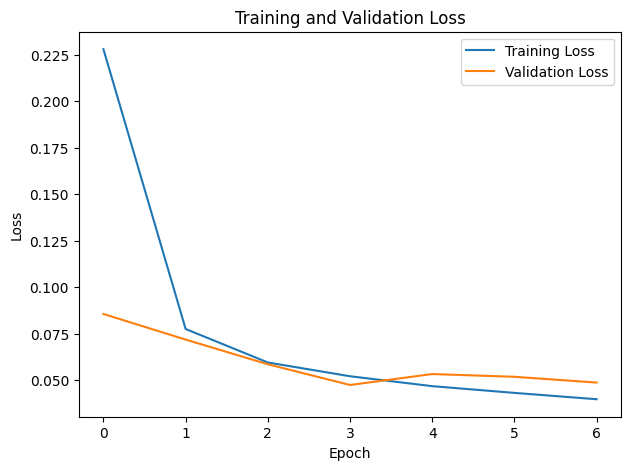

In [66]:
# Plot training and validation loss
plt.figure(figsize=(7, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

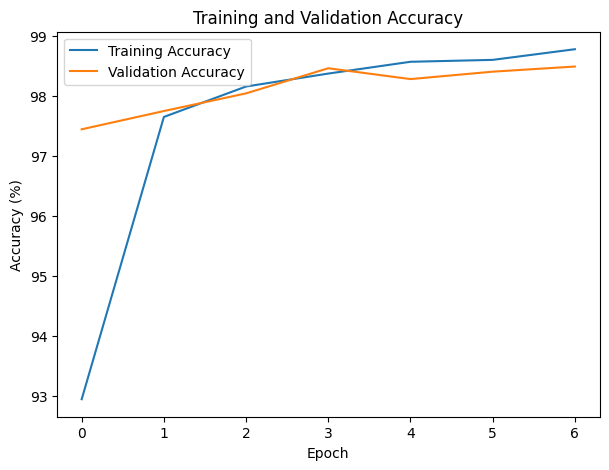

In [67]:
# Plot training and validation accuracy
plt.figure(figsize=(7, 5))
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [68]:
import csv
model.eval()

results = []

with torch.no_grad():
    for batch_number, x in enumerate(test_loader):
        x = x.to(device).float()

        output = model(x).argmax(dim=1)
        for out in output:
            results.append(out.item())

In [69]:
submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission['Label'] = results
submission.to_csv("/kaggle/working/submission.csv", index = False)